<a href="https://colab.research.google.com/github/RafaelAnga/Bootcamp_AI_BIT/blob/main/sales_colombia_PCA_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import of libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc


Import of Dataset

In [2]:
from google.colab import drive # Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os    # Library Necesary for connecting to folder
os.chdir('/content/drive/MyDrive/Projects/Sales_Colombia/DataSets')

#mostar lista de archivos
os.listdir()

['example_submission.csv',
 'test.csv',
 'train.csv',
 'encoder.pkl',
 'my_dir',
 'cleaned_train.csv',
 'catboost_info',
 'verification_predictions.csv']

# **Business Understanding and Exploratory Data Analysis (EDA)**

## Part 1: Business Understanding

Objective:
The goal of this project is to predict the variable VENTA, representing sales, using the provided dataset. This prediction will support data-driven insights into business performance and decision-making for commercial entities in Colombia.

Dataset Description:
The dataset originates from Colombia's Encuesta Anual de Comercio (EAC), a survey conducted to capture key economic indicators for the commerce sector.
link: https://microdatos.dane.gov.co/index.php/catalog/CII-Microdatos

Key characteristics of the dataset include:

Size:
7488 rows and 65 columns.

Variable Types:
Numerical: Majority of columns represent continuous values, such as costs, revenues, and workforce details.

Categorical: Columns like CORRELA_16 and CORRE_9 appear to classify businesses based on activity or sector.

Target Variable:
VENTA (Sales): The primary variable to predict. This value is critical for understanding business performance.

Potential Influential Features:
BRUTA (Gross Production): Indicates the total output, potentially related to sales.
CIMREP: Represents the cost of materials for installation, repair, and maintenance.
TOTPERSO: Total personnel employed.
ARRIENDO (Rent): A key expense that might influence sales outcomes.


## Part 2: Exploratory Data Analysis (EDA)

**Distribution of Target Variable:** VENTA

Initial exploration shows that the column VENTASNOP, a potential proxy for VENTA, has a uniform value of 0 across all entries.


**Key Observations:** The target variable requires validation or preprocessing as the current dataset provides no variability.

Feature Analysis
Correlation with Sales:
Since the target variable VENTASNOP shows no variability (The sum is equal to 0) correlations cannot yet be evaluated, and therefore can be safely dropped. However, exploratory focus can be shifted to high-priority features such as:


*   Gross Production (BRUTA): Examining its distribution and potential relationship with other cost variables.
*   Categorical Variables (CORRELA_16 and CORRE_9): Understanding their distribution to identify sector-based patterns.

Gross Production (BRUTA):

Distribution:

*   Range: [Min: ~1.36 million; Max: ~22 million].
*   Median: Appears skewed towards lower values.
*   Suggests high variability across businesses.

Workforce Features:

TOTPERSO (Total Personnel):

*   Averages and ranges show significant variation.
*   Expected to correlate with both costs and production capacity.


In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 65 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        7488 non-null   int64  
 1   V1           7488 non-null   int64  
 2   CORRELA_16   7488 non-null   object 
 3   CORRE_9      7488 non-null   object 
 4   IDOJ1        7483 non-null   float64
 5   IDAIO        7486 non-null   float64
 6   CIMREP       7488 non-null   float64
 7   BRUTA        7488 non-null   float64
 8   CONSUI       7488 non-null   float64
 9   GAS          7488 non-null   float64
 10  EMPAQUE      7488 non-null   float64
 11  HONORA       7488 non-null   float64
 12  COMISION     7488 non-null   float64
 13  ARRIENDO     7488 non-null   float64
 14  SEGURO       7488 non-null   float64
 15  ASEO         7488 non-null   float64
 16  ENERGIA      7488 non-null   float64
 17  COMUNICA     7488 non-null   float64
 18  PUBLICO      7488 non-null   float64
 19  FLETES

In [6]:
df_train.head()

,index,V1,CORRELA_16,CORRE_9,IDOJ1,IDAIO,CIMREP,BRUTA,CONSUI,GAS,...,INVINI,INVFIN,ROTACION,INVPRO,CTO,CTOINS,VENTASNOP,GASTOS,GASTOSNOP,GASTOPNOP
0,7627,1660771,464,464-465,11.0,1981.0,0.0,2238145.0,125841.0,0.0,...,1110417.0,1155317.0,25466077.0,1132867.0,25466077.0,25466077.0,0,25721984.0,82021.0,27468490.0
1,7937,1661445,473,473,14.0,2014.0,0.0,1905867.0,634274.0,0.0,...,251053.0,170247.0,9809655.0,210650.0,9809655.0,9809655.0,0,10456929.0,6667.0,11182951.0
2,4357,1222540,465,464-465,14.0,1981.0,0.0,22093125.0,6352377.5,714.0,...,13067906.0,10850543.0,9988335.0,11959224.5,9988335.0,9988335.0,0,17001301.0,1417890.0,26369223.0
3,6336,1229296,464,464-465,4.0,2004.0,0.0,1365034.0,514460.5,0.0,...,1912369.0,2331970.0,1941959.0,2122169.5,1941959.0,1941959.0,0,2452772.0,242273.0,3143151.0
4,2350,994677,4711-472,471-472,14.0,2010.0,0.0,5403923.0,2911758.0,0.0,...,848774.0,2482444.0,23583502.0,1665609.0,23583502.0,23583502.0,0,26796715.0,447269.0,29546092.0


In [7]:
df_test.head()

,Unnamed: 0,index,V1,CORRELA_16,CORRE_9,IDOJ1,IDAIO,CIMREP,BRUTA,CONSUI,...,INVINI,INVFIN,ROTACION,INVPRO,CTO,CTOINS,VENTASNOP,GASTOS,GASTOSNOP,GASTOPNOP
0,0,1333,991812,473,473,14.0,1990.0,0.0,489910.0,246745.5,...,66072.0,63424.0,3694524.0,64748.0,3694524.0,3694524.0,0,3956892.0,12836.0,4142446.0
1,1,1377,991942,466,466-469,14.0,2002.0,0.0,8440461.0,2358301.0,...,336859.0,1004246.0,10886884.0,670552.5,10886884.0,10886884.0,0,13477484.0,298682.0,17399015.0
2,2,2851,1008008,4741-4742,474 - 475,14.0,1978.0,0.0,4569572.0,809612.0,...,24130475.0,25228812.0,16350947.0,24679643.5,16350947.0,16350947.0,0,17274790.0,0.0,19297239.0
3,3,1503,992281,4773,476 - 477,14.0,2003.0,0.0,331331.0,42807.5,...,378310.0,419963.0,732671.0,399136.5,732671.0,732671.0,0,781852.0,4098.0,1013127.0
4,4,893,990651,473,473,13.0,1944.0,0.0,1487225.0,197195.0,...,333864.0,477655.0,9006654.0,405759.5,9006654.0,9006654.0,0,9226098.0,125991.0,9707030.0


In [8]:
X = df_train.drop(columns=['VENTA','V1','index','VENTASNOP'])
y = df_train['VENTA']
X_verify = df_test.drop(columns=['Unnamed: 0','V1','index','VENTASNOP'])

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CORRELA_16   7488 non-null   object 
 1   CORRE_9      7488 non-null   object 
 2   IDOJ1        7483 non-null   float64
 3   IDAIO        7486 non-null   float64
 4   CIMREP       7488 non-null   float64
 5   BRUTA        7488 non-null   float64
 6   CONSUI       7488 non-null   float64
 7   GAS          7488 non-null   float64
 8   EMPAQUE      7488 non-null   float64
 9   HONORA       7488 non-null   float64
 10  COMISION     7488 non-null   float64
 11  ARRIENDO     7488 non-null   float64
 12  SEGURO       7488 non-null   float64
 13  ASEO         7488 non-null   float64
 14  ENERGIA      7488 non-null   float64
 15  COMUNICA     7488 non-null   float64
 16  PUBLICO      7488 non-null   float64
 17  FLETES       7488 non-null   float64
 18  PUBLICI      7488 non-null   float64
 19  ADECUA

In [10]:
X_verify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CORRELA_16   2496 non-null   object 
 1   CORRE_9      2496 non-null   object 
 2   IDOJ1        2495 non-null   float64
 3   IDAIO        2495 non-null   float64
 4   CIMREP       2496 non-null   float64
 5   BRUTA        2496 non-null   float64
 6   CONSUI       2496 non-null   float64
 7   GAS          2496 non-null   float64
 8   EMPAQUE      2496 non-null   float64
 9   HONORA       2496 non-null   float64
 10  COMISION     2496 non-null   float64
 11  ARRIENDO     2496 non-null   float64
 12  SEGURO       2496 non-null   float64
 13  ASEO         2496 non-null   float64
 14  ENERGIA      2496 non-null   float64
 15  COMUNICA     2496 non-null   float64
 16  PUBLICO      2496 non-null   float64
 17  FLETES       2496 non-null   float64
 18  PUBLICI      2496 non-null   float64
 19  ADECUA

In [11]:
# Loop through each column in X to identify missing values
missing_data_details = {}
print(" Missing Data per category: ")
for column in X.columns:
    missing_count = X[column].isnull().sum()
    if missing_count > 0:  # Only consider columns with missing values
        missing_data_details[column] = missing_count

# Display the results
missing_data_details


 Missing Data per category: 


{'IDOJ1': 5,
 'IDAIO': 2,
 'TOTMUJ': 1,
 'TOTHOM': 2,
 'INVFIN': 3,
 'ROTACION': 10,
 'CTO': 1,
 'GASTOS': 1}

Exploration of Data suggests that the data has little data missing as decribed below:


*   DOJ1: 5
*   IDAIO: 2,
*   TOTMUJ: 1,
*   TOTHOM: 2,
*   INVFIN: 3,
*   ROTACION: 10,
*   CTO: 1,
*   GASTOS: 1

Though there are missing datapoints, they don't affect the initial insights due to their low percentage in the overall data. 25/7488 = 0.0033 or 0.33% of the total dataset.

## Dealing with missing data

*Remove missing data

In [12]:
# Step 1: One-Hot Encode the categorical columns for training data
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = ['CORRELA_16', 'CORRE_9', 'IDOJ1']  # List of categorical columns

# Fit the encoder on the training data
X_encoded = encoder.fit_transform(X[categorical_columns])

# Convert encoded data to DataFrame for easier handling
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Step 2: Combine the encoded categorical columns with the rest of the training data
X_encoded_combined = pd.concat([X.drop(columns=categorical_columns).reset_index(drop=True), X_encoded_df], axis=1)

# Check the combined training data
X_encoded_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 95 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IDAIO                 7486 non-null   float64
 1   CIMREP                7488 non-null   float64
 2   BRUTA                 7488 non-null   float64
 3   CONSUI                7488 non-null   float64
 4   GAS                   7488 non-null   float64
 5   EMPAQUE               7488 non-null   float64
 6   HONORA                7488 non-null   float64
 7   COMISION              7488 non-null   float64
 8   ARRIENDO              7488 non-null   float64
 9   SEGURO                7488 non-null   float64
 10  ASEO                  7488 non-null   float64
 11  ENERGIA               7488 non-null   float64
 12  COMUNICA              7488 non-null   float64
 13  PUBLICO               7488 non-null   float64
 14  FLETES                7488 non-null   float64
 15  PUBLICI              

In [13]:
from sklearn.impute import KNNImputer

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the KNNImputer to the training data (X_encoded_combined)
X_encoded_imputed = knn_imputer.fit_transform(X_encoded_combined)

# Convert back to DataFrame if necessary
X_encoded_imputed_df = pd.DataFrame(X_encoded_imputed, columns=X_encoded_combined.columns)


In [14]:
print(X_encoded_imputed.shape)
#X_encoded_imputed.head()

(7488, 95)


In [15]:
from sklearn.model_selection import train_test_split

# Step 4: Split the data into train and test (after encoding and imputing missing values)
X_train, X_test, y_train, y_test = train_test_split(X_encoded_imputed_df, y, test_size=0.3, random_state=42)

# Verify the split
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (5241, 95), (5241,)
Testing data shape: (2247, 95), (2247,)


### Handling of outliers with capping method and leaving them as is

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for outlier handling
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method='leave', z_thresh=3.0):  # Default: leave outliers
        self.method = method
        self.z_thresh = z_thresh

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Convert X (numpy array) to DataFrame
        X_df = pd.DataFrame(X)  # Assuming X has columns but no column names yet

        # Separate numerical columns from categorical ones
        numerical_cols = X_df.select_dtypes(include=['number']).columns
        categorical_cols = X_df.select_dtypes(exclude=['number']).columns

        if self.method == 'cap':
            # Capping outliers for numerical columns
            z_scores = ((X_df[numerical_cols] - X_df[numerical_cols].mean()) / X_df[numerical_cols].std()).abs()
            capped_X = X_df.copy()  # Create a copy to avoid modifying the original data
            for col in numerical_cols:  # Apply clipping column by column
                capped_X[col] = X_df[col].clip(
                    lower=X_df[col].mean() - self.z_thresh * X_df[col].std(),
                    upper=X_df[col].mean() + self.z_thresh * X_df[col].std()
                )
            return capped_X
        elif self.method == 'leave':
            # No outlier handling
            return X_df
        else:
            raise ValueError("Invalid method. Choose 'cap' or 'leave'.")

# Function to apply preprocessing
def preprocess_data(X, method='leave'):
    handler = OutlierHandler(method=method)
    X_preprocessed = handler.fit_transform(X)
    return X_preprocessed

# Example usage
for method in ['leave', 'cap']:
    print(f"Preprocessing with method: {method}")
    X_preprocessed = preprocess_data(X_encoded_imputed, method=method)
    print(f"Preprocessed data shape with '{method}': {X_preprocessed.shape}")


Preprocessing with method: leave
Preprocessed data shape with 'leave': (7488, 95)
Preprocessing with method: cap
Preprocessed data shape with 'cap': (7488, 95)


In [17]:
# Check if 'VENTASNOP' exists in X_train
#'VENTASNOP' in X_train.columns


In [18]:
# Define PCASelector for Regular PCA
class PCASelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=13):
        self.n_components = n_components

    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)
        return self

    def transform(self, X, y=None):
        return self.pca.transform(X)

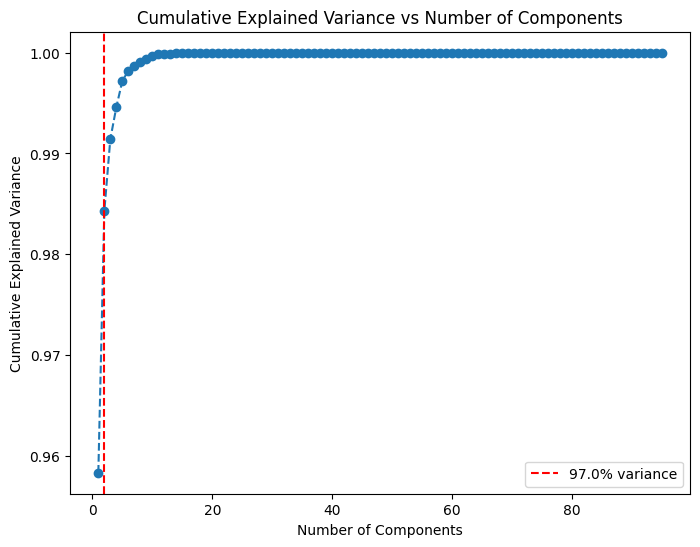

Optimal number of PCA components for 97% variance: 2


In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def optimal_pca_components(X, variance_threshold=0.97):
    # Fit PCA to the data
    pca = PCA().fit(X)

    # Compute the cumulative explained variance ratio
    cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

    # Find the number of components that explain at least 'variance_threshold' of the variance
    optimal_components = (cumulative_explained_variance >= variance_threshold).argmax() + 1

    # Plot the explained variance vs number of components
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.axvline(x=optimal_components, color='r', linestyle='--', label=f'{variance_threshold*100}% variance')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.show()

    return optimal_components

# Example usage:
X_preprocessed = preprocess_data(X_encoded_imputed, method='cap')  # Or use 'leave'
optimal_components = optimal_pca_components(X_preprocessed, variance_threshold=0.97)
print(f"Optimal number of PCA components for 97% variance: {optimal_components}")


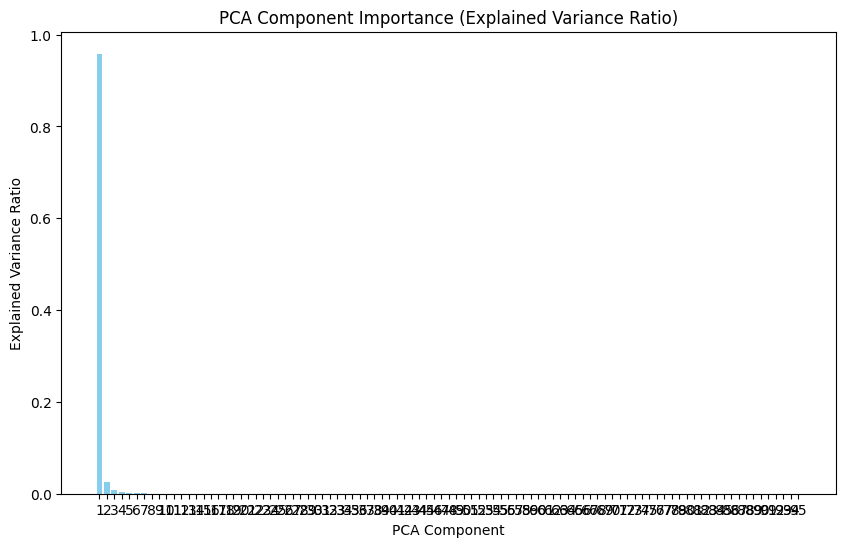

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_pca_component_importance(X):
    # Fit PCA to the data
    pca = PCA().fit(X)

    # Explained variance ratio for each component
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance ratio as a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
    plt.xlabel('PCA Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Component Importance (Explained Variance Ratio)')
    plt.xticks(range(1, len(explained_variance) + 1))  # Ensure x-ticks match number of components
    plt.show()

# Example usage:
X_preprocessed = preprocess_data(X_encoded_imputed, method='cap')  # Or use 'leave'
plot_pca_component_importance(X_preprocessed)


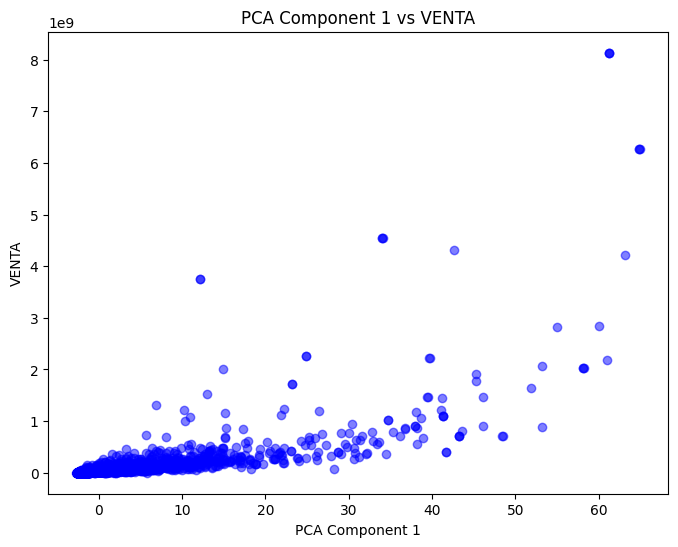

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'X_preprocessed' contains the feature data and 'y' contains the target ('VENTA')
def plot_pca_component_vs_venta(X, y):
    # Apply StandardScaler to the features (X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to the scaled data
    pca = PCA(n_components=1)  # We are interested in the first component
    X_pca = pca.fit_transform(X_scaled)

    # Plot the first PCA component against VENTA
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca, y, alpha=0.5, color='b')
    plt.title('PCA Component 1 vs VENTA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('VENTA')
    plt.show()

# Example usage
plot_pca_component_vs_venta(X_preprocessed, y)


### Boxplot to check for outliers in most significant variables

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
#Test Models with PCA Integrated
# Define models

models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "HistGradientBoost": HistGradientBoostingRegressor(max_iter=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    "Elastic Net": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "Decision Tree":DecisionTreeRegressor(random_state=42),
    "Polynomial Regression (Degree 2)": Pipeline([
        ('poly_features', PolynomialFeatures(degree=2)),
        ('linear_regression', LinearRegression())
    ])
}


# Store results
results = []

# Nested loop for testing all combinations
outlier_methods = ['cap', 'leave']
for outlier_method in outlier_methods:
    for name, model in models.items():
        print(f"Testing {name} with outlier method '{outlier_method}'...")

        try:
            # Create pipeline
            pipeline = Pipeline([
                ('outlier_handler', OutlierHandler(method=outlier_method)),
                ('scaler', StandardScaler()),
                ('pca', PCASelector(n_components=2)),  # Regular PCA with 20 components
                ('model', model)
            ])

            # Fit the pipeline on raw training data (scaling is handled inside the pipeline)
            pipeline.fit(X_train, y_train)

           # Make predictions on test data
            y_pred = pipeline.predict(X_test)  # Corrected here to use raw X_test data

            # Evaluate performance
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Save results
            results.append({
                'Model': name,
                'Outlier Handling': outlier_method,
                'MSE': mse,
                'MAE': mae,
                'R²': r2
            })
            print(f"{name} -> MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        except Exception as e:
            print(f"Error with {name}, outlier '{outlier_method}': {e}")

# Step 6: Display Results
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)


# Optional: Save results to a CSV for analysis
#results_df.to_csv('model_results_with_mae.csv', index=False)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
Testing Gradient Boosting with outlier method 'cap'...
Gradient Boosting -> MSE: 77478280650334560.0000, MAE: 42663504.1647, R²: 0.4583
Testing Extra Trees with outlier method 'cap'...
Extra Trees -> MSE: 56234379951610960.0000, MAE: 40024348.3408, R²: 0.6068
Testing XGBoost with outlier method 'cap'...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Error with XGBoost, outlier 'cap': 'super' object has no attribute '__sklearn_tags__'
Testing HistGradientBoost with outlier method 'cap'...
HistGradientBoost -> MSE: 83002682414063184.0000, MAE: 41115160.4187, R²: 0.4197
Testing Random Forest with outlier method 'cap'...
Random Forest -> MSE: 61128131747494136.0000, MAE: 40622238.8313, R²: 0.5726
Testing KNN with outlier method 'cap'...
KNN -> MSE: 65508484920643880.0000, MAE: 40317869.6849, R²: 0.5420
Testing LightGBM with outlier method 'cap'...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5241, number of used features: 2
[LightGBM] [Info] Start training from score 47079603.582329


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LightGBM -> MSE: 81278302107425888.0000, MAE: 40854760.6878, R²: 0.4317
Testing CatBoost with outlier method 'cap'...
CatBoost -> MSE: 92615690373060832.0000, MAE: 41224405.2201, R²: 0.3525
Testing Elastic Net with outlier method 'cap'...
Elastic Net -> MSE: 65835435474857520.0000, MAE: 49967137.8721, R²: 0.5397
Testing Decision Tree with outlier method 'cap'...
Decision Tree -> MSE: 83368428712447888.0000, MAE: 47378084.8255, R²: 0.4171
Testing Polynomial Regression (Degree 2) with outlier method 'cap'...
Polynomial Regression (Degree 2) -> MSE: 52017588544325520.0000, MAE: 51718036.2142, R²: 0.6363
Testing Gradient Boosting with outlier method 'leave'...
Gradient Boosting -> MSE: 21215602333220308.0000, MAE: 26054468.0168, R²: 0.8517
Testing Extra Trees with outlier method 'leave'...
Extra Trees -> MSE: 23669464519297956.0000, MAE: 27368870.6225, R²: 0.8345
Testing XGBoost with outlier method 'leave'...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Error with XGBoost, outlier 'leave': 'super' object has no attribute '__sklearn_tags__'
Testing HistGradientBoost with outlier method 'leave'...
HistGradientBoost -> MSE: 66162639562995136.0000, MAE: 37519719.1075, R²: 0.5374
Testing Random Forest with outlier method 'leave'...
Random Forest -> MSE: 21123204196690004.0000, MAE: 27114779.5962, R²: 0.8523
Testing KNN with outlier method 'leave'...
KNN -> MSE: 40577511770142328.0000, MAE: 32178282.8734, R²: 0.7163
Testing LightGBM with outlier method 'leave'...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5241, number of used features: 2
[LightGBM] [Info] Start training from score 47079603.582329


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LightGBM -> MSE: 66555335650535528.0000, MAE: 37534710.2004, R²: 0.5347
Testing CatBoost with outlier method 'leave'...
CatBoost -> MSE: 59344498201692632.0000, MAE: 34075693.6773, R²: 0.5851
Testing Elastic Net with outlier method 'leave'...
Elastic Net -> MSE: 20444521579850364.0000, MAE: 28476618.7959, R²: 0.8571
Testing Decision Tree with outlier method 'leave'...
Decision Tree -> MSE: 18615430784342296.0000, MAE: 29301919.4611, R²: 0.8698
Testing Polynomial Regression (Degree 2) with outlier method 'leave'...
Polynomial Regression (Degree 2) -> MSE: 24756417087847648.0000, MAE: 31952673.2925, R²: 0.8269

Results Summary:
                               Model Outlier Handling           MSE  \
0                  Gradient Boosting              cap  7.747828e+16   
1                        Extra Trees              cap  5.623438e+16   
2                  HistGradientBoost              cap  8.300268e+16   
3                      Random Forest              cap  6.112813e+16   
4          

In [23]:
sorted_results = results_df.sort_values(by='MSE', ascending=True)
print("\nTop Performers by MSE:")
print(sorted_results.head())


Top Performers by MSE:
                Model Outlier Handling           MSE           MAE        R²
18      Decision Tree            leave  1.861543e+16  2.930192e+07  0.869846
17        Elastic Net            leave  2.044452e+16  2.847662e+07  0.857058
13      Random Forest            leave  2.112320e+16  2.711478e+07  0.852313
10  Gradient Boosting            leave  2.121560e+16  2.605447e+07  0.851666
11        Extra Trees            leave  2.366946e+16  2.736887e+07  0.834510


In [24]:
from sklearn.model_selection import cross_val_score

# Store cross-validation results
cv_results = []

# Nested loop for cross-validation
outlier_methods = ['cap', 'leave']
for outlier_method in outlier_methods:
    for name, model in models.items():
        print(f"Cross-validating {name} with outlier method '{outlier_method}'...")

        # Create pipeline for cross-validation
        pipeline = Pipeline([
            ('outlier_handler', OutlierHandler(method=outlier_method)),
            ('scaler', StandardScaler()),
            ('pca', PCASelector(n_components=13)),
            ('model', model)
        ])

        try:
            # Perform cross-validation (using negative MSE for maximization)
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

            # Convert negative MSE to positive MSE
            cv_scores = -cv_scores

            # Calculate the mean and standard deviation of the cross-validation scores
            mean_mse = np.mean(cv_scores)
            std_mse = np.std(cv_scores)

            # Save results
            cv_results.append({
                'Model': name,
                'Outlier Handling': outlier_method,
                'Mean MSE': mean_mse,
                'Std MSE': std_mse
            })
            print(f"{name} -> Mean MSE: {mean_mse:.4f}, Std MSE: {std_mse:.4f}")

        except Exception as e:
            print(f"Error with {name}, outlier '{outlier_method}': {e}")

# Step 4: Display Cross-Validation Results
cv_results_df = pd.DataFrame(cv_results)
print("\nCross-Validation Results Summary:")
print(cv_results_df)


# Sort by Mean MSE
sorted_cv_results = cv_results_df.sort_values(by='Mean MSE', ascending=True)
print("\nTop Performers by Mean MSE (from Cross-Validation):")
print(sorted_cv_results.head())


Cross-validating Gradient Boosting with outlier method 'cap'...
Gradient Boosting -> Mean MSE: 14587204689570628.0000, Std MSE: 10226732373547722.0000
Cross-validating Extra Trees with outlier method 'cap'...
Extra Trees -> Mean MSE: 10493259814913664.0000, Std MSE: 4916311259886836.0000
Cross-validating XGBoost with outlier method 'cap'...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__

XGBoost -> Mean MSE: nan, Std MSE: nan
Cross-validating HistGradientBoost with outlier method 'cap'...
HistGradientBoost -> Mean MSE: 19047316803611184.0000, Std MSE: 8654032947627912.0000
Cross-validating Random Forest with outlier method 'cap'...
Random Forest -> Mean MSE: 15034332699173892.0000, Std MSE: 8504674951681513.0000
Cross-validating KNN with outlier method 'cap'...
KNN -> Mean MSE: 14118853581329124.0000, Std MSE: 5971464394181282.0000
Cross-validating LightGBM with outlier method 'cap'...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4192, number of used features: 13
[LightGBM] [Info] Start training from score 49253556.686779


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 46796504.426131


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 45972800.823392


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 47595617.922231


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 45780056.525113


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

LightGBM -> Mean MSE: 18598788920726200.0000, Std MSE: 8860421359405816.0000
Cross-validating CatBoost with outlier method 'cap'...
CatBoost -> Mean MSE: 19886629472182656.0000, Std MSE: 12029638278941668.0000
Cross-validating Elastic Net with outlier method 'cap'...
Elastic Net -> Mean MSE: 21027299793697860.0000, Std MSE: 11590514814951972.0000
Cross-validating Decision Tree with outlier method 'cap'...
Decision Tree -> Mean MSE: 18443255263251816.0000, Std MSE: 11506936502606282.0000
Cross-validating Polynomial Regression (Degree 2) with outlier method 'cap'...
Polynomial Regression (Degree 2) -> Mean MSE: 18054774847425516.0000, Std MSE: 12636476478885620.0000
Cross-validating Gradient Boosting with outlier method 'leave'...
Gradient Boosting -> Mean MSE: 4016563581501057.5000, Std MSE: 2819750772816617.5000
Cross-validating Extra Trees with outlier method 'leave'...
Extra Trees -> Mean MSE: 2316536479890549.0000, Std MSE: 1391543476355477.5000
Cross-validating XGBoost with outlier

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__

XGBoost -> Mean MSE: nan, Std MSE: nan
Cross-validating HistGradientBoost with outlier method 'leave'...
HistGradientBoost -> Mean MSE: 13561938008796488.0000, Std MSE: 6522651974021753.0000
Cross-validating Random Forest with outlier method 'leave'...
Random Forest -> Mean MSE: 4940748910239702.0000, Std MSE: 2169227634720800.2500
Cross-validating KNN with outlier method 'leave'...
KNN -> Mean MSE: 8648542772790126.0000, Std MSE: 4960879869886098.0000
Cross-validating LightGBM with outlier method 'leave'...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4192, number of used features: 13
[LightGBM] [Info] Start training from score 49253556.686779


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 46796504.426131


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 45972800.823392


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 47595617.922231


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4193, number of used features: 13
[LightGBM] [Info] Start training from score 45780056.525113


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate 

LightGBM -> Mean MSE: 13033383267731632.0000, Std MSE: 6479085426236380.0000
Cross-validating CatBoost with outlier method 'leave'...
CatBoost -> Mean MSE: 6752416429334438.0000, Std MSE: 4659709879797599.0000
Cross-validating Elastic Net with outlier method 'leave'...
Elastic Net -> Mean MSE: 6278962099778862.0000, Std MSE: 2357065745003706.0000
Cross-validating Decision Tree with outlier method 'leave'...
Decision Tree -> Mean MSE: 5639829141568706.0000, Std MSE: 4476738017040269.5000
Cross-validating Polynomial Regression (Degree 2) with outlier method 'leave'...
Polynomial Regression (Degree 2) -> Mean MSE: 98010067253507152.0000, Std MSE: 188223887291207456.0000

Cross-Validation Results Summary:
                               Model Outlier Handling      Mean MSE  \
0                  Gradient Boosting              cap  1.458720e+16   
1                        Extra Trees              cap  1.049326e+16   
2                            XGBoost              cap           NaN   
3    

In [25]:
# Identify the best model configuration based on the lowest MSE
best_config = results_df.loc[results_df['MSE'].idxmin()]

# Extract the optimal number of components and model
best_model_name = best_config['Model']
best_outlier_handling = best_config['Outlier Handling']

print("\nBest Model Configuration:")
print(f"Model: {best_model_name}")
print(f"Outlier Handling: {best_outlier_handling}")
print(f"MSE: {best_config['MSE']:.4f}, MAE: {best_config['MAE']:.4f}, R²: {best_config['R²']:.4f}")


Best Model Configuration:
Model: Decision Tree
Outlier Handling: leave
MSE: 18615430784342296.0000, MAE: 29301919.4611, R²: 0.8698


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

# Define the parameter distribution for Decision Tree
param_dist = {
    'model__max_depth': randint(3, 15),  # Maximum depth of the tree
    'model__min_samples_split': randint(2, 20),  # Minimum samples required to split a node
    'model__min_samples_leaf': randint(1, 10),   # Minimum samples required at each leaf node
    'model__ccp_alpha': uniform(0.0, 0.01),  # Pruning parameter
    'model__max_features': ['auto', 'sqrt', 'log2', None]   # Proportion of features considered at each split
}

# Create a pipeline with scaling and the ElasticNet model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', DecisionTreeRegressor(random_state=42))  # ElasticNet model
])

# Set up RandomizedSearchCV for Decision Tree
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=300, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=42,verbose=1)

# Fit the randomized search on training data
random_search.fit(X_train, y_train)

# Get the best parameters and pipeline
best_params = random_search.best_params_
best_pipeline = random_search.best_estimator_

# Print the best hyperparameters and score
print(f"Best Hyperparameters: {best_params}")
print(f"Best MSE from Randomized Search: {-random_search.best_score_:.4f}")


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
425 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
218 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/

Best Hyperparameters: {'model__ccp_alpha': 0.004636984049399821, 'model__max_depth': 12, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}
Best MSE from Randomized Search: 1419176573612925.5000


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform

# Define the parameter distribution for ElasticNet
param_dist = {
    'model__alpha': uniform(0.001, 10),  # Regularization strength
    'model__l1_ratio': uniform(0.1, 0.9),  # Balance between L1 (lasso) and L2 (ridge) penalties
}

# Create a pipeline with scaling and the ElasticNet model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', ElasticNet(random_state=42))  # ElasticNet model
])

# Set up RandomizedSearchCV for ElasticNet
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=300, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=42)

# Fit the randomized search on training data
random_search.fit(X_train, y_train)

# Get the best parameters and pipeline
best_params = random_search.best_params_
best_pipeline = random_search.best_estimator_

# Print the best hyperparameters and score
print(f"Best Hyperparameters: {best_params}")
print(f"Best MSE from Randomized Search: {-random_search.best_score_:.4f}")


Best Hyperparameters: {'model__alpha': 8.130010091300775, 'model__l1_ratio': 0.9997459059575176}
Best MSE from Randomized Search: 992044998965.9397


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.308e+16, tolerance: 2.647e+16
  model = cd_fast.enet_coordinate_descent(


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# Define the parameter distribution for XGBoost
param_dist = {
    'model__n_estimators': randint(50, 500),  # Number of trees (boosting rounds)
    'model__max_depth': randint(3, 15),  # Maximum depth of each tree
    'model__learning_rate': uniform(0.01, 0.3),  # Learning rate (shrinkage)
    'model__subsample': uniform(0.6, 0.4),  # Subsample ratio of the training instance
    'model__colsample_bytree': uniform(0.6, 0.4),  # Subsample ratio of columns when constructing each tree
    'model__gamma': uniform(0, 5),  # Minimum loss reduction to make a split
    'model__reg_alpha': uniform(0, 1),  # L1 regularization (alpha)
    'model__reg_lambda': uniform(1, 5)  # L2 regularization (lambda)
}

# Create a pipeline with scaling (not needed for XGBoost but keeping for consistency) and XGBoost model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))  # XGBoost model
])

# Set up RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,
                                   n_iter=300, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=42, verbose=1)

# Fit the randomized search on training data
random_search.fit(X_train, y_train)

# Get the best parameters and pipeline
best_params = random_search.best_params_
best_pipeline = random_search.best_estimator_

# Print the best hyperparameters and score
print(f"Best Hyperparameters: {best_params}")
print(f"Best MSE from Randomized Search: {-random_search.best_score_:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


KeyboardInterrupt: 

In [ ]:
# Create the best pipeline based on the selected configuration
best_model = models[best_model_name]  # Fetch the best model
outlier_handler = OutlierHandler(method=best_outlier_handling)  # Use the best outlier method

# Create the final pipeline with the selected configurations
final_pipeline = Pipeline([
    ('outlier_handler', outlier_handler),
    ('scaler', StandardScaler()),
    ('pca', PCASelector(n_components=13)),  # Or use the n_components based on PCA tuning
    ('model', best_model)
])

# Train the final pipeline on the entire training data
final_pipeline.fit(X_train, y_train)

# Now you can use the final pipeline to predict on new data (like the verification set or test set)
y_final_pred = final_pipeline.predict(X_test)  # Example on the test set

# Evaluate the final model on the test set
final_mse = mean_squared_error(y_test, y_final_pred)
final_mae = mean_absolute_error(y_test, y_final_pred)
final_r2 = r2_score(y_test, y_final_pred)

print("\nFinal Model Evaluation:")
print(f"Model: {best_model_name}")
print(f"Final MSE: {final_mse:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final R²: {final_r2:.4f}")


## Preprocessing the test data in order to prepare it for prediction

In [ ]:
# Loop through each column in X to identify missing values
missing_data_details = {}
print(" Missing Data per category: ")
for column in df_test.columns:
    missing_count = df_test[column].isnull().sum()
    if missing_count > 0:  # Only consider columns with missing values
        missing_data_details[column] = missing_count

# Display the results
missing_data_details

In [ ]:
# Encode the categorical columns in X_verify using the already fitted encoder
X_verify_encoded = encoder.transform(X_verify[categorical_columns])

# Convert encoded data to DataFrame
X_verify_encoded_df = pd.DataFrame(
    X_verify_encoded,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Combine with the rest of the verification data
X_verify_combined = pd.concat([
    X_verify.drop(columns=categorical_columns).reset_index(drop=True),
    X_verify_encoded_df.reset_index(drop=True)
], axis=1)

# Step 3: Align columns with training set
for col in X_train.columns:
    if col not in X_verify_combined.columns:
        X_verify_combined[col] = 0

# Ensure the columns in X_verify are in the same order as in X_train
X_verify_combined = X_verify_combined[X_train.columns]

# Check the combined verification data
X_verify_combined.info()


In [ ]:
# Step 2: Handle missing values in the verification data (X_verify_combined)
X_verify_imputed = knn_imputer.transform(X_verify_combined)

# Convert back to DataFrame if necessary
X_verify_processed = pd.DataFrame(X_verify_imputed, columns=X_verify_combined.columns)


## Using the model to predict the verification data

In [ ]:
# Step 5: Make predictions using the trained pipeline
# Ensure that the pipeline already includes the necessary preprocessing steps (scaling, encoding, PCA, etc.)
y_verify_pred = best_pipeline.predict(X_verify_processed)

# Step 6: Save predictions
df_test['Predictions'] = y_verify_pred

# Save the predictions along with the index column
df_test[['index', 'Predictions']].to_csv('verification_predictions.csv', index=False)

# Print a preview of the predictions
print(df_test[['index', 'Predictions']].head())


In [ ]:
# Define the path where the predictions file should be saved
output_path = "/content/drive/MyDrive/Projects/Sales_Colombia/Predictions/sales-colombia_PCA_Outliers.csv"

# Step 7: Create the DataFrame with the original index and the predictions
submission_df = pd.DataFrame({
    'index': df_test['index'],  # Use original indices from df_test
    'VENTA': y_verify_pred      # Predicted values
})

# Step 8: Save the DataFrame to a CSV file
#submission_df.to_csv(output_path, index=False)

# Confirm the file was saved
print(f"Predictions saved at: {output_path}")

# Print a preview of the saved file
print(pd.read_csv(output_path).head())

# Summary of process:

Imported the Dataset:

* Loaded the dataset into features (X) and target variable (y).

Removed Irrelevant Features:

* Dropped the VENTASNOP column from X because it was filled with zeros and provided no value to the analysis.

Identified and Handled Missing Values:

* Inspected the dataset for missing values.
Decided to remove rows with missing data to ensure clean input for analysis.

Encoded Categorical Variables:
* Utilized One-Hot Encoding to transform categorical variables (CORRELA_16, CORRE_9, and IDOJ1) into numerical format for compatibility with machine learning algorithms.

Handled Outliers:
* Designed a custom outlier handling strategy using capping (via Z-scores) to limit extreme values without removing rows.

Split the Dataset:
* Split the dataset into training and testing sets using an 80-20 split to evaluate model performance on unseen data.

Scaled the Features:
* Standardized the data using StandardScaler to normalize values, ensuring all features contributed equally to the models.

Dimensionality Reduction:
* Applied Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.
* Compared results between PCA and Kernel PCA (RBF) methods to test linear and nonlinear dimensionality reduction.

Modeling:
* Built pipelines with three models:
1. XGBoost
2. Random Forest
3. Ridge Regression

* Trained and evaluated each model using different combinations of:
1. Outlier handling strategies (cap, leave).
2. Dimensionality reduction methods (pca, kernel_pca).

Model Evaluation:
* Assessed model performance using Mean Squared Error (MSE) and R² scores to identify the best-performing combination of preprocessing and modeling.

# Pipelining to train data

In [ ]:
#!jupyter nbconvert --to pdf "/content/drive/MyDrive/Projects/Sales_Colombia/sales-colombia_CappingOutliers.ipynb"